In [1]:
using DataFrames, CSV, MLJ, MLJBase, CairoMakie

In [2]:
# Import training dataset
lichen_training = CSV.read("C:/Users/jnovoa/Downloads/lichen_training.csv", DataFrame, missingstring="NA") |>
x -> DataFrames.select(x, "Total.lichen", "basal_area", "PL", "mean_Long", "mean_Lat", "Aspect_south", "SNR", "SMR", "SX") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon", "lat", "south", "snr", "smr", "sx"]) |>
dropmissing |>
x -> coerce(x, :pl=>Continuous, :sx=>Continuous, :snr=>Multiclass, :smr=>Multiclass);

In [3]:
# schema 
schema(lichen_training)

┌───────────┬───────────────────────────────────┬───────────────┐
│ _.names   │ _.types                           │ _.scitypes    │
├───────────┼───────────────────────────────────┼───────────────┤
│ biomass   │ Float64                           │ Continuous    │
│ basalarea │ Float64                           │ Continuous    │
│ pl        │ Float64                           │ Continuous    │
│ lon       │ Float64                           │ Continuous    │
│ lat       │ Float64                           │ Continuous    │
│ south     │ Float64                           │ Continuous    │
│ snr       │ CategoricalValue{String1, UInt32} │ Multiclass{3} │
│ smr       │ CategoricalValue{Int64, UInt32}   │ Multiclass{5} │
│ sx        │ Float64                           │ Continuous    │
└───────────┴───────────────────────────────────┴───────────────┘
_.nrows = 77


In [4]:
# Split predictors/responde variable
y, X = unpack(lichen_training, ==(:biomass), _->true; rng=1010);

In [6]:
# Load a model and create a pipeline
model = @load RandomForestRegressor pkg=DecisionTree verbosity=0
pipe = @pipeline Standardizer OneHotEncoder model target=v->log.(v) inverse=v->exp.(v)

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase C:\Users\jnovoa\.julia\packages\MLJBase\QXObv\src\composition\models\pipelines.jl:372


Pipeline281(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    random_forest_regressor = RandomForestRegressor(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 10,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0,
            rng = Random._GLOBAL_RNG()),
    target = WrappedFunction(
            f = var"#11#12"()),
    inverse = WrappedFunction(
            f = var"#13#14"()))

In [24]:
# Model tunning
r = [range(pipe, :(random_forest_regressor.max_depth), lower=1, upper=5),
     range(pipe, :(random_forest_regressor.n_trees), lower=10, upper=50)]
tuned_model = TunedModel(model=pipe,
                         tuning=Grid(resolution=100),
                         resampling=CV(),
                         range=r,
                         measure=rms)
m = machine(tuned_model, X, y) |> fit!;

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jnovoa\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Attempting to evaluate 205 models.
└ @ MLJTuning C:\Users\jnovoa\.julia\packages\MLJTuning\bjRHJ\src\tuned_models.jl:680
Evaluating over 205 metamodels:   1%[>                        ]  ETA: 0:00:05

Evaluating over 205 metamodels:   1%[>                        ]  ETA: 0:00:10

Evaluating over 205 metamodels:   2%[>                        ]  ETA: 0:00:08

Evaluating over 205 metamodels:   2%[>                        ]  ETA: 0:00:08

Evaluating over 205 metamodels:   3%[>                        ]  ETA: 0:00:07

Evaluating over 205 metamodels:   3%[>                        ]  ETA: 0:00:07

Evaluating over 205 metamodels:   4%[>                        ]  ETA: 0:00:06

Evaluating over 205 metamodels:   4%[=>                       ]  ETA: 0:00:06

Evaluating over 205 metamodels:   5%[=>                       ]  ETA: 0:00:06

Evaluating over 205 metamodels:   5%[=>                       ]  ETA: 0:00:06

Evaluating over 205 metamodels:   6%[=>                       ]  ETA: 0:00:06

Evaluating over 205 metamodels:   6%[=>                       ]  ETA: 0:00:06

Evaluating over 205 metamodels:   7%[=>                       ]  ETA: 0:00:06

Evaluating over 205 metamodels:   7%[=>                       ]  ETA: 0:00:06

Evaluating over 205 metamodels:   8%[=>                       ]  ETA: 0:00:06

Evaluating over 205 metamodels:   8%[==>                      ]  ETA: 0:00:06

Evaluating over 205 metamodels:   9%[==>                      ]  ETA: 0:00:06

Evaluating over 205 metamodels:   9%[==>                      ]  ETA: 0:00:06

Evaluating over 205 metamodels:  10%[==>                      ]  ETA: 0:00:06

Evaluating over 205 metamodels:  10%[==>                      ]  ETA: 0:00:05

Evaluating over 205 metamodels:  11%[==>                      ]  ETA: 0:00:05

Evaluating over 205 metamodels:  11%[==>                      ]  ETA: 0:00:05

Evaluating over 205 metamodels:  12%[==>                      ]  ETA: 0:00:05

Evaluating over 205 metamodels:  12%[===>                     ]  ETA: 0:00:05

Evaluating over 205 metamodels:  13%[===>                     ]  ETA: 0:00:05

Evaluating over 205 metamodels:  13%[===>                     ]  ETA: 0:00:05

Evaluating over 205 metamodels:  14%[===>                     ]  ETA: 0:00:05

Evaluating over 205 metamodels:  14%[===>                     ]  ETA: 0:00:05

Evaluating over 205 metamodels:  15%[===>                     ]  ETA: 0:00:05

Evaluating over 205 metamodels:  15%[===>                     ]  ETA: 0:00:05

Evaluating over 205 metamodels:  16%[===>                     ]  ETA: 0:00:05

Evaluating over 205 metamodels:  16%[====>                    ]  ETA: 0:00:05

Evaluating over 205 metamodels:  17%[====>                    ]  ETA: 0:00:05

Evaluating over 205 metamodels:  17%[====>                    ]  ETA: 0:00:05

Evaluating over 205 metamodels:  18%[====>                    ]  ETA: 0:00:05

Evaluating over 205 metamodels:  18%[====>                    ]  ETA: 0:00:05

Evaluating over 205 metamodels:  19%[====>                    ]  ETA: 0:00:05

Evaluating over 205 metamodels:  19%[====>                    ]  ETA: 0:00:05

Evaluating over 205 metamodels:  20%[====>                    ]  ETA: 0:00:05

Evaluating over 205 metamodels:  20%[=====>                   ]  ETA: 0:00:05

Evaluating over 205 metamodels:  20%[=====>                   ]  ETA: 0:00:05

Evaluating over 205 metamodels:  21%[=====>                   ]  ETA: 0:00:05

Evaluating over 205 metamodels:  21%[=====>                   ]  ETA: 0:00:05

Evaluating over 205 metamodels:  22%[=====>                   ]  ETA: 0:00:05

Evaluating over 205 metamodels:  22%[=====>                   ]  ETA: 0:00:05

Evaluating over 205 metamodels:  23%[=====>                   ]  ETA: 0:00:05

Evaluating over 205 metamodels:  23%[=====>                   ]  ETA: 0:00:05

Evaluating over 205 metamodels:  24%[=====>                   ]  ETA: 0:00:05

Evaluating over 205 metamodels:  24%[======>                  ]  ETA: 0:00:05

Evaluating over 205 metamodels:  25%[======>                  ]  ETA: 0:00:05

Evaluating over 205 metamodels:  25%[======>                  ]  ETA: 0:00:05

Evaluating over 205 metamodels:  26%[======>                  ]  ETA: 0:00:04

Evaluating over 205 metamodels:  26%[======>                  ]  ETA: 0:00:04

Evaluating over 205 metamodels:  27%[======>                  ]  ETA: 0:00:04

Evaluating over 205 metamodels:  27%[======>                  ]  ETA: 0:00:04

Evaluating over 205 metamodels:  28%[======>                  ]  ETA: 0:00:04

Evaluating over 205 metamodels:  28%[=======>                 ]  ETA: 0:00:04

Evaluating over 205 metamodels:  29%[=======>                 ]  ETA: 0:00:04

Evaluating over 205 metamodels:  29%[=======>                 ]  ETA: 0:00:04

Evaluating over 205 metamodels:  30%[=======>                 ]  ETA: 0:00:04

Evaluating over 205 metamodels:  30%[=======>                 ]  ETA: 0:00:04

Evaluating over 205 metamodels:  31%[=======>                 ]  ETA: 0:00:04

Evaluating over 205 metamodels:  31%[=======>                 ]  ETA: 0:00:04

Evaluating over 205 metamodels:  32%[=======>                 ]  ETA: 0:00:04

Evaluating over 205 metamodels:  32%[========>                ]  ETA: 0:00:04

Evaluating over 205 metamodels:  33%[========>                ]  ETA: 0:00:04

Evaluating over 205 metamodels:  33%[========>                ]  ETA: 0:00:04

Evaluating over 205 metamodels:  34%[========>                ]  ETA: 0:00:04

Evaluating over 205 metamodels:  34%[========>                ]  ETA: 0:00:04

Evaluating over 205 metamodels:  35%[========>                ]  ETA: 0:00:04

Evaluating over 205 metamodels:  35%[========>                ]  ETA: 0:00:04

Evaluating over 205 metamodels:  36%[========>                ]  ETA: 0:00:04

Evaluating over 205 metamodels:  36%[=========>               ]  ETA: 0:00:04

Evaluating over 205 metamodels:  37%[=========>               ]  ETA: 0:00:04

Evaluating over 205 metamodels:  37%[=========>               ]  ETA: 0:00:04

Evaluating over 205 metamodels:  38%[=========>               ]  ETA: 0:00:04

Evaluating over 205 metamodels:  38%[=========>               ]  ETA: 0:00:04

Evaluating over 205 metamodels:  39%[=========>               ]  ETA: 0:00:04

Evaluating over 205 metamodels:  39%[=========>               ]  ETA: 0:00:04

Evaluating over 205 metamodels:  40%[=========>               ]  ETA: 0:00:04

Evaluating over 205 metamodels:  40%[==========>              ]  ETA: 0:00:04

Evaluating over 205 metamodels:  40%[==========>              ]  ETA: 0:00:03

Evaluating over 205 metamodels:  41%[==========>              ]  ETA: 0:00:03

Evaluating over 205 metamodels:  41%[==========>              ]  ETA: 0:00:03

Evaluating over 205 metamodels:  42%[==========>              ]  ETA: 0:00:03

Evaluating over 205 metamodels:  42%[==========>              ]  ETA: 0:00:03

Evaluating over 205 metamodels:  43%[==========>              ]  ETA: 0:00:03

Evaluating over 205 metamodels:  43%[==========>              ]  ETA: 0:00:03

Evaluating over 205 metamodels:  44%[==========>              ]  ETA: 0:00:03

Evaluating over 205 metamodels:  44%[===========>             ]  ETA: 0:00:03

Evaluating over 205 metamodels:  45%[===========>             ]  ETA: 0:00:03

Evaluating over 205 metamodels:  45%[===========>             ]  ETA: 0:00:03

Evaluating over 205 metamodels:  46%[===========>             ]  ETA: 0:00:03

Evaluating over 205 metamodels:  46%[===========>             ]  ETA: 0:00:03

Evaluating over 205 metamodels:  47%[===========>             ]  ETA: 0:00:03

Evaluating over 205 metamodels:  47%[===========>             ]  ETA: 0:00:03

Evaluating over 205 metamodels:  48%[===========>             ]  ETA: 0:00:03

Evaluating over 205 metamodels:  48%[============>            ]  ETA: 0:00:03

Evaluating over 205 metamodels:  49%[============>            ]  ETA: 0:00:03

Evaluating over 205 metamodels:  49%[============>            ]  ETA: 0:00:03

Evaluating over 205 metamodels:  50%[============>            ]  ETA: 0:00:03

Evaluating over 205 metamodels:  50%[============>            ]  ETA: 0:00:03

Evaluating over 205 metamodels:  51%[============>            ]  ETA: 0:00:03

Evaluating over 205 metamodels:  51%[============>            ]  ETA: 0:00:03

Evaluating over 205 metamodels:  52%[============>            ]  ETA: 0:00:03

Evaluating over 205 metamodels:  52%[=============>           ]  ETA: 0:00:03

Evaluating over 205 metamodels:  53%[=============>           ]  ETA: 0:00:03

Evaluating over 205 metamodels:  53%[=============>           ]  ETA: 0:00:03

Evaluating over 205 metamodels:  54%[=============>           ]  ETA: 0:00:03

Evaluating over 205 metamodels:  54%[=============>           ]  ETA: 0:00:03

Evaluating over 205 metamodels:  55%[=============>           ]  ETA: 0:00:03

Evaluating over 205 metamodels:  55%[=============>           ]  ETA: 0:00:03

Evaluating over 205 metamodels:  56%[=============>           ]  ETA: 0:00:03

Evaluating over 205 metamodels:  56%[==============>          ]  ETA: 0:00:03

Evaluating over 205 metamodels:  57%[==============>          ]  ETA: 0:00:03

Evaluating over 205 metamodels:  57%[==============>          ]  ETA: 0:00:02

Evaluating over 205 metamodels:  58%[==============>          ]  ETA: 0:00:02

Evaluating over 205 metamodels:  58%[==============>          ]  ETA: 0:00:02

Evaluating over 205 metamodels:  59%[==============>          ]  ETA: 0:00:02

Evaluating over 205 metamodels:  59%[==============>          ]  ETA: 0:00:02

Evaluating over 205 metamodels:  60%[==============>          ]  ETA: 0:00:02

Evaluating over 205 metamodels:  60%[===============>         ]  ETA: 0:00:02

Evaluating over 205 metamodels:  60%[===============>         ]  ETA: 0:00:02

Evaluating over 205 metamodels:  61%[===============>         ]  ETA: 0:00:02

Evaluating over 205 metamodels:  61%[===============>         ]  ETA: 0:00:02

Evaluating over 205 metamodels:  62%[===============>         ]  ETA: 0:00:02

Evaluating over 205 metamodels:  62%[===============>         ]  ETA: 0:00:02

Evaluating over 205 metamodels:  63%[===============>         ]  ETA: 0:00:02

Evaluating over 205 metamodels:  63%[===============>         ]  ETA: 0:00:02

Evaluating over 205 metamodels:  64%[===============>         ]  ETA: 0:00:02

Evaluating over 205 metamodels:  64%[================>        ]  ETA: 0:00:02

Evaluating over 205 metamodels:  65%[================>        ]  ETA: 0:00:02

Evaluating over 205 metamodels:  65%[================>        ]  ETA: 0:00:02

Evaluating over 205 metamodels:  66%[================>        ]  ETA: 0:00:02

Evaluating over 205 metamodels:  66%[================>        ]  ETA: 0:00:02

Evaluating over 205 metamodels:  67%[================>        ]  ETA: 0:00:02

Evaluating over 205 metamodels:  67%[================>        ]  ETA: 0:00:02

Evaluating over 205 metamodels:  68%[================>        ]  ETA: 0:00:02

Evaluating over 205 metamodels:  68%[=================>       ]  ETA: 0:00:02

Evaluating over 205 metamodels:  69%[=================>       ]  ETA: 0:00:02

Evaluating over 205 metamodels:  69%[=================>       ]  ETA: 0:00:02

Evaluating over 205 metamodels:  70%[=================>       ]  ETA: 0:00:02

Evaluating over 205 metamodels:  70%[=================>       ]  ETA: 0:00:02

Evaluating over 205 metamodels:  71%[=================>       ]  ETA: 0:00:02

Evaluating over 205 metamodels:  71%[=================>       ]  ETA: 0:00:02

Evaluating over 205 metamodels:  72%[=================>       ]  ETA: 0:00:02

Evaluating over 205 metamodels:  72%[==================>      ]  ETA: 0:00:02

Evaluating over 205 metamodels:  73%[==================>      ]  ETA: 0:00:02

Evaluating over 205 metamodels:  73%[==================>      ]  ETA: 0:00:02

Evaluating over 205 metamodels:  74%[==================>      ]  ETA: 0:00:01

Evaluating over 205 metamodels:  74%[==================>      ]  ETA: 0:00:01

Evaluating over 205 metamodels:  75%[==================>      ]  ETA: 0:00:01

Evaluating over 205 metamodels:  75%[==================>      ]  ETA: 0:00:01

Evaluating over 205 metamodels:  76%[==================>      ]  ETA: 0:00:01

Evaluating over 205 metamodels:  76%[===================>     ]  ETA: 0:00:01

Evaluating over 205 metamodels:  77%[===================>     ]  ETA: 0:00:01

Evaluating over 205 metamodels:  77%[===================>     ]  ETA: 0:00:01

Evaluating over 205 metamodels:  78%[===================>     ]  ETA: 0:00:01

Evaluating over 205 metamodels:  78%[===================>     ]  ETA: 0:00:01

Evaluating over 205 metamodels:  79%[===================>     ]  ETA: 0:00:01

Evaluating over 205 metamodels:  79%[===================>     ]  ETA: 0:00:01

Evaluating over 205 metamodels:  80%[===================>     ]  ETA: 0:00:01

Evaluating over 205 metamodels:  80%[====================>    ]  ETA: 0:00:01

Evaluating over 205 metamodels:  80%[====================>    ]  ETA: 0:00:01

Evaluating over 205 metamodels:  81%[====================>    ]  ETA: 0:00:01

Evaluating over 205 metamodels:  81%[====================>    ]  ETA: 0:00:01

Evaluating over 205 metamodels:  82%[====================>    ]  ETA: 0:00:01

Evaluating over 205 metamodels:  82%[====================>    ]  ETA: 0:00:01

Evaluating over 205 metamodels:  83%[====================>    ]  ETA: 0:00:01

Evaluating over 205 metamodels:  83%[====================>    ]  ETA: 0:00:01

Evaluating over 205 metamodels:  84%[====================>    ]  ETA: 0:00:01

Evaluating over 205 metamodels:  84%[=====================>   ]  ETA: 0:00:01

Evaluating over 205 metamodels:  85%[=====================>   ]  ETA: 0:00:01

Evaluating over 205 metamodels:  85%[=====================>   ]  ETA: 0:00:01

Evaluating over 205 metamodels:  86%[=====================>   ]  ETA: 0:00:01

Evaluating over 205 metamodels:  86%[=====================>   ]  ETA: 0:00:01

Evaluating over 205 metamodels:  87%[=====================>   ]  ETA: 0:00:01

Evaluating over 205 metamodels:  87%[=====================>   ]  ETA: 0:00:01

Evaluating over 205 metamodels:  88%[=====================>   ]  ETA: 0:00:01

Evaluating over 205 metamodels:  88%[======================>  ]  ETA: 0:00:01

Evaluating over 205 metamodels:  89%[======================>  ]  ETA: 0:00:01

Evaluating over 205 metamodels:  89%[======================>  ]  ETA: 0:00:01

Evaluating over 205 metamodels:  90%[======================>  ]  ETA: 0:00:01

Evaluating over 205 metamodels:  90%[======================>  ]  ETA: 0:00:01

Evaluating over 205 metamodels:  91%[======================>  ]  ETA: 0:00:01

Evaluating over 205 metamodels:  91%[======================>  ]  ETA: 0:00:00

Evaluating over 205 metamodels:  92%[======================>  ]  ETA: 0:00:00

Evaluating over 205 metamodels:  92%[=======================> ]  ETA: 0:00:00

Evaluating over 205 metamodels:  93%[=======================> ]  ETA: 0:00:00

Evaluating over 205 metamodels:  93%[=======================> ]  ETA: 0:00:00

Evaluating over 205 metamodels:  94%[=======================> ]  ETA: 0:00:00

Evaluating over 205 metamodels:  94%[=======================> ]  ETA: 0:00:00

Evaluating over 205 metamodels:  95%[=======================> ]  ETA: 0:00:00

Evaluating over 205 metamodels:  95%[=======================> ]  ETA: 0:00:00

Evaluating over 205 metamodels:  96%[=======================> ]  ETA: 0:00:00

Evaluating over 205 metamodels:  96%[========================>]  ETA: 0:00:00

Evaluating over 205 metamodels:  97%[========================>]  ETA: 0:00:00

Evaluating over 205 metamodels:  97%[========================>]  ETA: 0:00:00

Evaluating over 205 metamodels:  98%[========================>]  ETA: 0:00:00

Evaluating over 205 metamodels:  98%[========================>]  ETA: 0:00:00

Evaluating over 205 metamodels:  99%[========================>]  ETA: 0:00:00

Evaluating over 205 metamodels:  99%[========================>]  ETA: 0:00:00

Evaluating over 205 metamodels: 100%[========================>]  ETA: 0:00:00

Evaluating over 205 metamodels: 100%[=========================] Time: 0:00:05


In [25]:
# Check fitted parameters
fp = fitted_params(m)

(best_model = Pipeline281,
 best_fitted_params = (inverse = (fitresult = nothing,),
                       random_forest_regressor = (forest = Ensemble of Decision Trees
Trees:      16
Avg Leaves: 19.1875
Avg Depth:  5.0,),
                       one_hot_encoder = (fitresult = OneHotEncoderResult,),
                       standardizer = Dict(:basalarea => (19.90597402597402, 9.59526339559761), :sx => (9.883116883116884, 23.760301935201667), :lat => (55.97332400649351, 0.5664634649325856), :pl => (57.05194805194805, 43.025052709193105), :south => (0.7041558441558441, 0.19658499333253884), :lon => (-125.32716337662336, 0.881650658304238)),
                       target = (fitresult = nothing,),
                       machines = Machine[Machine{WrappedFunction,…}, Machine{Standardizer,…}, Machine{OneHotEncoder,…}, Machine{RandomForestRegressor,…}, Machine{WrappedFunction,…}],
                       fitted_params_given_machine = LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machine{Wrappe

In [26]:
m.report.best_history_entry

(model = Pipeline281,
 measure = [RootMeanSquaredError()],
 measurement = [901.8948505659317],
 per_fold = [[1146.8793603620072, 900.3228200751527, 559.3531870236886, 1132.0326589628376, 659.2477127072372, 851.8162981475932]],)

In [27]:
m.report.best_model

Pipeline281(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    random_forest_regressor = RandomForestRegressor(
            max_depth = 5,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 16,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0,
            rng = Random._GLOBAL_RNG()),
    target = WrappedFunction(
            f = var"#11#12"()),
    inverse = WrappedFunction(
            f = var"#13#14"()))

In [28]:
ŷ = predict(m);

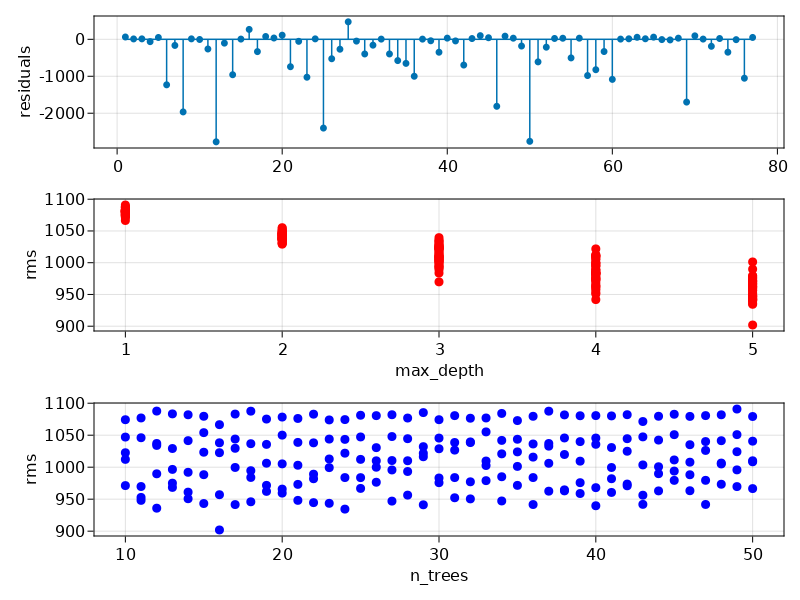

In [29]:
f = Figure()

ax1 = Axis(f[1, 1])
ax1.ylabel = "residuals"
stem!(ax1, ŷ - y)

ax2 = Axis(f[2, 1])
ax2.xlabel = "max_depth"
ax2.ylabel = "rms"
scatter!(ax2, Float64.(m.report.plotting.parameter_values[:, 1]), m.report.plotting.measurements, color=:red)

ax3 = Axis(f[3, 1])
ax3.xlabel = "n_trees"
ax3.ylabel = "rms"
scatter!(ax3, Float64.(m.report.plotting.parameter_values[:, 2]), m.report.plotting.measurements, color=:blue)

f

# splitting into train/test datasets

In [30]:
# Split into train/test datasets
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=1010)

([52, 61, 5, 54, 23, 15, 37, 45, 34, 12  …  56, 21, 14, 77, 40, 27, 67, 18, 2, 53], [35, 50, 39, 38, 46, 76, 29, 69, 7, 60, 59, 17, 30, 43, 51])

In [34]:
# Fit the machine using ideal params
pipe.random_forest_regressor.max_depth = 5
pipe.random_forest_regressor.n_trees = 16
m2 = machine(pipe, X, y)
fit!(m2, rows=train)

┌ Info: Training Machine{Pipeline281,…}.
└ @ MLJBase C:\Users\jnovoa\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{WrappedFunction,…}.
└ @ MLJBase C:\Users\jnovoa\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\jnovoa\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{WrappedFunction,…}.
└ @ MLJBase C:\Users\jnovoa\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{OneHotEncoder,…}.
└ @ MLJBase C:\Users\jnovoa\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Spawning 3 sub-features to one-hot encode feature :snr.
└ @ MLJModels C:\Users\jnovoa\.julia\packages\MLJModels\GKDnU\src\builtins\Transformers.jl:1142
┌ Info: Spawning 5 sub-features to one-hot encode feature :smr.
└ @ MLJModels C:\Users\jnovoa\.julia\packages\MLJModels\GKDnU\src\builtins\Transformers.jl:1142
┌ Info: Training Machine{RandomForestRegressor,…}.
└ @ MLJBase C:\Users\jn

Machine{Pipeline281,…} trained 1 time; caches data
  args: 
    1:	Source @054 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{Multiclass{5}}}}`
    2:	Source @634 ⏎ `AbstractVector{Continuous}`


In [35]:
# Check trained parameters
fp2 = fitted_params(m2)

(inverse = (fitresult = nothing,),
 random_forest_regressor = (forest = Ensemble of Decision Trees
Trees:      16
Avg Leaves: 17.6875
Avg Depth:  5.0,),
 one_hot_encoder = (fitresult = OneHotEncoderResult,),
 standardizer = Dict(:basalarea => (19.79112903225806, 9.601286816904013), :sx => (10.709677419354838, 25.131384008631873), :lat => (55.93379500806451, 0.5288022800765516), :pl => (56.854838709677416, 43.05271141066059), :south => (0.7035483870967741, 0.20347067919589265), :lon => (-125.27535296774195, 0.8342122443459429)),
 target = (fitresult = nothing,),
 machines = Machine[Machine{WrappedFunction,…}, Machine{Standardizer,…}, Machine{OneHotEncoder,…}, Machine{RandomForestRegressor,…}, Machine{WrappedFunction,…}],
 fitted_params_given_machine = LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machine{WrappedFunction,…} => (fitresult = nothing,), Machine{Standardizer,…} => Dict(:basalarea => (19.79112903225806, 9.601286816904013), :sx => (10.709677419354838, 25.131384008631873), :la

In [37]:
# Make predictions on test and train subsets
y_test_pred = predict(m2, rows=test)
y_train_pred = predict(m2, rows=train);

In [40]:
@show rms(y_test_pred, y[test])
@show rms(y_train_pred, y[train]);

rms(y_test_pred, y[test]) = 1309.9334275923247
rms(y_train_pred, y[train]) = 738.3362911051693


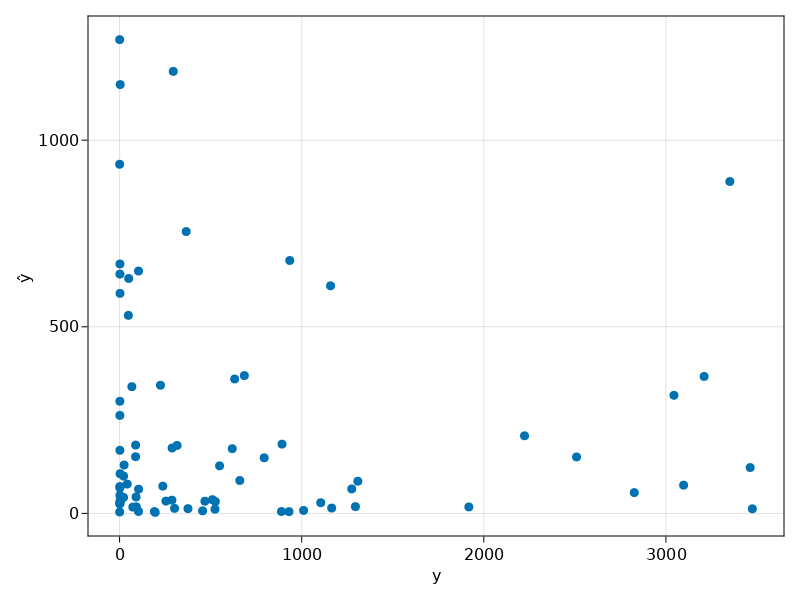

In [93]:
f = Figure()

ax1 = Axis(f[1, 1])
ax1.xlabel = "y"
ax1.ylabel = "ŷ"
# scatter!(ax1, y[train], y_train_pred, color=:blue)
scatter!(ax1, y, vcat(y_test_pred, y_train_pred))

f

# Predict on new dataset

In [22]:
# Import CSV to dataframe, select the same columns used for training
lichen = CSV.read("C:/Users/jnovoa/Downloads/predicted_biomass_Nov2021.csv", DataFrame) |>
x -> select(x, :BASAL_AREA, :PL, :LON) |>
x -> rename(x, ["basalarea", "pl", "lon"]);

In [ ]:
# Predict on a new dataset
biomass = exp.(predict(m, lichen))

In [ ]:
# Combine new dataset with predictions
results = hcat(lichen, biomass)

In [ ]:
# Export results to CSV
CSV.write("C:/Users/julio/Downloads/predicted_biomass_rf.csv", results)